# Obesity Risk Prediction with Neural Networks and Hyperparameter Tuning

## Introduction
In this Kaggle notebook, I analyze the Estimation of Obesity Levels [dataset](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition) from the UC Irvine Machine Learning Repository dataset. This dataset offers insights into how eating habits and physical conditions correlate with obesity levels, with the goal of building effective predictive models.

You can check this model in action in [this Streamlit App](https://obesitypred.streamlit.app/).

## Dataset Overview
We are using a custom-modified version of the dataset that I uploaded to Kaggle, which includes:

- **original_data.csv**: Raw data with random NULL values.
- **data_ready.csv**: A cleaned and imputed subset of 1,000 samples for model training and testing. Columns 'gender' and 'Weight' were removed to enhance model performance and avoid collinearity.
- **test_later.csv**: Additional data for final model evaluation.

## Model Training and Evaluation
Two neural network models were trained and tuned. The key results for the best performing neural network are:

### On `data_ready.csv`:
- **Accuracy**: 0.69

|              | precision | recall | f1-score | support |
|--------------|-----------|--------|----------|---------|
| **0**        | 0.88      | 0.45   | 0.60     | 102     |
| **1**        | 0.62      | 0.94   | 0.75     | 98      |
| **accuracy** |           |        | 0.69     | 200     |
| **macro avg**| 0.75      | 0.69   | 0.67     | 200     |
| **weighted avg**| 0.76  | 0.69   | 0.67     | 200     |

### On `test_later.csv`:
- **Accuracy**: 0.75

|              | precision | recall | f1-score | support |
|--------------|-----------|--------|----------|---------|
| **0**        | 0.93      | 0.56   | 0.70     | 539     |
| **1**        | 0.67      | 0.96   | 0.78     | 491     |
| **accuracy** |           |        | 0.75     | 1030    |
| **macro avg**| 0.80      | 0.76   | 0.74     | 1030    |
| **weighted avg**| 0.81  | 0.75   | 0.74     | 1030    |


These have been the results for a default threshold of 0.5. However, at its optimal threshold calculated below, a better generalization that balances the classes 0 and 1 is achieved though the recall performance of the class 1 decreases to 0.86.

The recall for identifying obesity, our primary objective, shows a strong performance, reflecting the model’s effectiveness in detecting individuals with obesity. This notebook details the model development process, including data preprocessing, feature engineering, and hyperparameter tuning.

# Importing Libraries and Defining Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import f_classif
from keras_tuner import RandomSearch, HyperModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, recall_score

2024-08-10 21:49:22.651570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 21:49:22.652017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 21:49:22.654275: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 21:49:22.661298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 21:49:22.671564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def prep_data(datos_input, var_cont, var_categ):
    di_cont = []
    di_cat = []
    if len(var_cont) != 0:
        di_cont = pd.DataFrame(datos_input[var_cont], columns = var_cont)
    if len(var_categ) != 0:
        di_cat = datos_input[var_categ]
        di_cat = pd.get_dummies(di_cat, columns = var_categ, drop_first = True, dtype=int)
    if len(var_cont) == 0:
        data_input = pd.concat([di_cat], axis=1)
    elif len(var_categ) == 0:
        data_input = pd.concat([di_cont], axis=1)
    else:
        data_input = pd.concat([di_cont,di_cat], axis=1)
    return data_input, di_cont, di_cat
def convert_binary_columns_to_str(df: pd.DataFrame) -> pd.DataFrame:
    # Iterate through each column in the DataFrame
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        # Check if the column contains exactly two unique values and they are 0 and 1
        if len(unique_values) == 2 and set(unique_values) == {0, 1}:
            # Convert the column to type str
            df[column] = df[column].astype(str)
    return df
def DataPrep(data, data2):
    y = data['NObeyesdad'].astype(int)
    del data['NObeyesdad']
    y2 = data2['NObeyesdad']
    del data2['NObeyesdad']
    data = convert_binary_columns_to_str(data)
    data2 = convert_binary_columns_to_str(data2)
    categ = data.select_dtypes(include=['object', 'category']).columns.tolist()
    cont = data.select_dtypes(exclude=['object', 'category']).columns.tolist()
    data_inputn, di_contn, di_catn = prep_data(data, cont, categ)
    X = data_inputn.copy()
    X2 = data2.copy()
    inputs, cont, categ = prep_data(X2, cont, categ)
    return X, y, inputs, y2
def TestModelAccuracy(model,X_test,y_test):
    y_pred = model.predict(X_test)
    # Convert probabilities to binary class labels
    y_pred = (y_pred > 0.5).astype(int).flatten()
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
def plot_accuracy_recall_vs_threshold(model, X_test, y_test):
    """
    Plot accuracy and recall as a function of different threshold values.

    Parameters:
    model : trained Keras model
        The trained Sequential model.
    X_test : numpy array or pandas DataFrame
        The test features.
    y_test : numpy array or pandas Series
        The true labels for the test set.
    """
    # Get the predicted probabilities for the positive class
    y_prob = model.predict(X_test).ravel()  # Flatten the array if it's 2D with a single column

    # Define a range of threshold values from 0 to 1
    thresholds = np.linspace(0, 1, 100)
    
    # Initialize lists to store metrics
    accuracies = []
    recalls = []

    for threshold in thresholds:
        # Apply the threshold to get binary predictions
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate accuracy and recall
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        # Append metrics to lists
        accuracies.append(accuracy)
        recalls.append(recall)

    # Plot accuracy and recall vs. threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Accuracy and Recall vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
import numpy as np
from sklearn.metrics import precision_recall_curve
def find_optimal_threshold(model, X_test, y_test, min_precision=0.7):
    """
    Find the optimal threshold for a given model to maximize recall while maintaining a minimum precision.

    Parameters:
    model : trained Keras model
        The trained Sequential model.
    X_test : numpy array or pandas DataFrame
        The test features.
    y_test : numpy array or pandas Series
        The true labels for the test set.
    min_precision : float
        The minimum acceptable precision value.

    Returns:
    float
        The optimal threshold value that maximizes recall while maintaining the minimum precision.
    """
    
    # Get the predicted probabilities for the positive class
    y_prob = model.predict(X_test).ravel()  # Flatten the array if it's 2D with a single column

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Find the threshold that maximizes recall while keeping precision above min_precision
    optimal_threshold = None
    max_recall = 0

    for i in range(len(precision)):
        if precision[i] >= min_precision:
            optimal_threshold = thresholds[i] if i < len(thresholds) else 1.0
            max_recall = recall[i]
            break

    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Precision at Optimal Threshold: {precision[i]}")
    print(f"Max Recall at Optimal Threshold: {max_recall}")

    return optimal_threshold
def TestModel_Threshold(model, x, y, umbral):
    """
    Evaluate the model with a custom threshold and print the classification report.

    Parameters:
    model : trained Keras model
        The trained Sequential model.
    x : numpy array or pandas DataFrame
        The test features.
    y : numpy array or pandas Series
        The true labels for the test set.
    umbral : float
        The custom threshold to apply.
    """
    # Make predictions (probabilities)
    probabilities = model.predict(x).ravel()  # Flatten the array if it's 2D with a single column
    
    # Define a custom threshold
    custom_threshold = umbral
    
    # Apply the custom threshold
    predictions = (probabilities >= custom_threshold).astype(int)
    print("Accuracy:", accuracy_score(y, predictions))
    # Print classification report
    print(classification_report(y, predictions))

# Data Prep
As mentioned above, I am using a modified version of the Estimation of Obesity Levels Based On Eating Habits and Physical Condition from UC Irvine. I will upload a notebook with the respective EDA in the future :)

In [3]:
seed = 7679

In [4]:
data = pd.read_csv('data/data_ready.csv')
data2 = pd.read_csv('data/test_later.csv')
data.head()

,Age,Height,FCVC,NCP,CH2O,FAF,TUE,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
0,20.738469,1.759933,2.627031,3.832911,2.993448,2.000000,1.425903,1,1,Sometimes,0,0,no,Public_Transport_Walking,0.0
1,29.721964,1.918859,2.041376,3.000000,1.120213,1.055450,0.000000,1,1,Sometimes,0,0,Sometimes_Frequently_Always,Public_Transport_Walking,1.0
2,24.825393,1.603501,2.996186,1.134042,1.270166,0.073065,1.551934,1,1,Sometimes,0,0,no,Public_Transport_Walking,1.0
3,20.811580,1.741193,3.000000,3.000000,1.768111,0.616503,0.968151,1,1,Sometimes,0,0,Sometimes_Frequently_Always,Public_Transport_Walking,1.0
4,18.000000,1.770000,3.000000,3.000000,2.000000,1.000000,1.000000,1,1,Sometimes,0,0,Sometimes_Frequently_Always,Public_Transport_Walking,0.0


In [5]:
X, y, inputs, y2 = DataPrep(data, data2)

In [6]:
selector = SelectKBest(score_func=f_classif, k=5)

X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
inputs = inputs[selected_features]

In [7]:
selected_features

Index(['Age', 'family_history_with_overweight_1', 'FAVC_1', 'CAEC_Sometimes',
       'SCC_1'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=seed)

# Traininig the Neural Network
Let's train the first Neural Network with only 1 hidden layer:

In [9]:
def FirstNN(X_train, y_train):
    # Red Neuronal con una sola capa oculta
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Hidden layer with 64 neurons
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    # Compile the model with AUC as a metric
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=[Recall()])
    
    # Fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    
    return model

In [10]:
model1 = FirstNN(X_train,y_train)

Epoch 1/100


I0000 00:00:1723319363.672526   20023 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 21:49:23.672804: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9417 - recall: 0.7726 - val_loss: 0.6833 - val_recall: 0.0000e+00
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7054 - recall: 0.2175 - val_loss: 0.6840 - val_recall: 0.1311
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6861 - recall: 0.0561 - val_loss: 0.6859 - val_recall: 0.9836
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6871 - recall: 0.6389 - val_loss: 0.6802 - val_recall: 0.9836
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6747 - recall: 0.6061 - val_loss: 0.6626 - val_recall: 0.0000e+00
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6687 - recall: 0.3174 - val_loss: 0.6585 - val_recall: 0.0984
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6618 - recall: 0.2687 - val_loss: 0.6536 - val_recall: 0.1311
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6549 - recall: 0.4104 - val_loss: 0.6468 - val_recall: 0.0000e+00
Epoch 9/100
20/

# Hyperparameter Tuning
Now, we will dive into Hyperparameter Tuning using 2 hidden layers:

In [11]:
def HyperModel(hp):
    model = Sequential()
    # Tune the number of units in the first hidden layer
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    model.add(Dense(units=hp_units_1, activation='relu', input_dim=X_train.shape[1]))
    
    # Tune the number of units in the second hidden layer
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    model.add(Dense(units=hp_units_2, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=[Recall()])
    return model
tuner = RandomSearch(
    HyperModel,
    objective='val_recall',
    max_trials=10,
    executions_per_trial=3,
)

Reloading Tuner from ./untitled_project/tuner0.json


In [12]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
modelBest = tuner.hypermodel.build(best_hps)
history = modelBest.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8405 - recall_2: 0.4939 - val_loss: 0.6738 - val_recall_2: 0.0000e+00
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6925 - recall_2: 0.0756 - val_loss: 0.7406 - val_recall_2: 1.0000
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7148 - recall_2: 0.7022 - val_loss: 0.7021 - val_recall_2: 1.0000
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6774 - recall_2: 0.7548 - val_loss: 0.6682 - val_recall_2: 0.7213
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6600 - recall_2: 0.7383 - val_loss: 0.6656 - val_recall_2: 0.9836
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6585 - recall_2: 0.7678 - val_loss: 0.6239 - val_recall_2: 0.0000e+00
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6230 - recall_2: 0.3777 - val_loss: 0.6088 - val_recall_2: 0.9344
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5932 - recall_2: 0.9367 - val_loss: 0.5974

# Testing the Models
Now that we have the models ready, we will test them with the train data and with the additional data.

## Manual Model

In [15]:
auc = roc_auc_score(y_test, (model1.predict(X_test) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.69


In [16]:
auc = roc_auc_score(y2, (model1.predict(inputs) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
AUC: 0.76


In [17]:
TestModelAccuracy(model1,X_test,y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
Accuracy: 0.69
[[46 56]
 [ 6 92]]
              precision    recall  f1-score   support

           0       0.88      0.45      0.60       102
           1       0.62      0.94      0.75        98

    accuracy                           0.69       200
   macro avg       0.75      0.69      0.67       200
weighted avg       0.76      0.69      0.67       200



In [18]:
TestModelAccuracy(model1,inputs,y2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
Accuracy: 0.7504854368932039
[[304 235]
 [ 22 469]]
              precision    recall  f1-score   support

           0       0.93      0.56      0.70       539
           1       0.67      0.96      0.78       491

    accuracy                           0.75      1030
   macro avg       0.80      0.76      0.74      1030
weighted avg       0.81      0.75      0.74      1030



## Hyperparameter Model

In [19]:
auc = roc_auc_score(y_test, (modelBest.predict(X_test) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
AUC: 0.71


In [20]:
auc = roc_auc_score(y2, (modelBest.predict(inputs) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
AUC: 0.77


In [21]:
TestModelAccuracy(modelBest,X_test,y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
Accuracy: 0.705
[[50 52]
 [ 7 91]]
              precision    recall  f1-score   support

           0       0.88      0.49      0.63       102
           1       0.64      0.93      0.76        98

    accuracy                           0.70       200
   macro avg       0.76      0.71      0.69       200
weighted avg       0.76      0.70      0.69       200



In [22]:
TestModelAccuracy(modelBest,inputs,y2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
Accuracy: 0.7592233009708738
[[315 224]
 [ 24 467]]
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       539
           1       0.68      0.95      0.79       491

    accuracy                           0.76      1030
   macro avg       0.80      0.77      0.75      1030
weighted avg       0.81      0.76      0.75      1030



# Finding the Optimal Threshold
Finding the optimal threshold for this exercise is about finding the sweet spot in which we maximize the recall for class 1 and class 0, while we try to improve accuracy as much as we can:

In [23]:
optimal_threshold = find_optimal_threshold(modelBest,inputs,y2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
Optimal Threshold: 0.6250295042991638
Precision at Optimal Threshold: 0.7009345794392523
Max Recall at Optimal Threshold: 0.7637474541751528


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


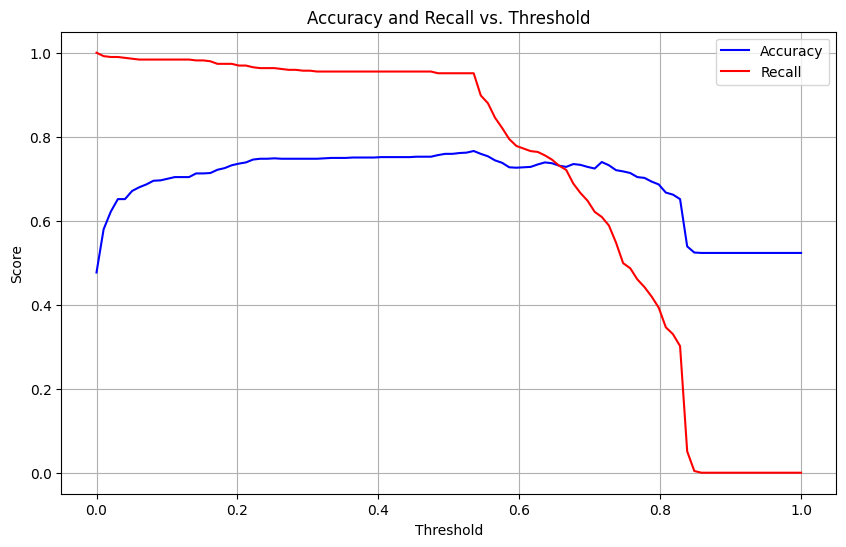

In [24]:
plot_accuracy_recall_vs_threshold(modelBest, inputs, y2)

In [25]:
# The best threshold seems to be around 0.55
TestModel_Threshold(modelBest, inputs, y2,0.55)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
Accuracy: 0.7543689320388349
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       539
           1       0.69      0.89      0.78       491

    accuracy                           0.75      1030
   macro avg       0.77      0.76      0.75      1030
weighted avg       0.78      0.75      0.75      1030



In [26]:
# The optimal threshold that comes from the function
TestModel_Threshold(modelBest,inputs, y2,optimal_threshold)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
Accuracy: 0.7320388349514563
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       539
           1       0.70      0.76      0.73       491

    accuracy                           0.73      1030
   macro avg       0.73      0.73      0.73      1030
weighted avg       0.73      0.73      0.73      1030



# Conclusions
This analysis demonstrates the effectiveness of neural networks in predicting obesity levels based on eating habits and physical conditions. The best-performing neural network model achieved an accuracy of 0.69 on the training data (`data_ready.csv`) and 0.75 on the additional test data (`test_later.csv`), indicating a reasonable generalization to new data.

### Key Findings:
1. **Recall for Identifying Obesity**: The model showed a strong recall score of 0.94 on the training set and 0.96 on the test set for the class identifying obesity. This reflects the model's high effectiveness in correctly identifying individuals with obesity, which is crucial for early intervention and treatment.

2. **Optimal Threshold**: The model's performance is balanced and achieves a better generalization at a threshold of around 0.61, however we have favored the class 1 by setting it at 0.55 for the Streamlit App.
  
3. **Model Performance**: Despite the high recall, the overall accuracy was moderate, indicating potential room for improvement in terms of precision and reducing false positives. The confusion matrix analysis reveals that while the model is adept at identifying true cases of obesity, there are still challenges in accurately predicting non-obese individuals.
  
4. **Feature Impact**: The neural network models' performance underscores the importance of feature selection and preprocessing. The exclusion of certain features like 'gender' and 'Weight' was aimed at enhancing model performance and reducing collinearity, which appears to have been effective.

### Future Work:
- **Hyperparameter Tuning**: Further tuning of the hyperparameters and exploring different architectures of neural networks could lead to improved performance.
- **Feature Engineering**: Additional feature engineering and the inclusion of more relevant features could help in boosting model accuracy.
- **Ensemble Methods**: Combining neural networks with other models, such as Random Forests, might offer enhanced predictive power through ensemble methods.

The results of this study affirm the potential of neural networks in medical and health-related predictive analytics, specifically in the area of obesity risk prediction. The strong recall scores are particularly promising for practical applications where correctly identifying cases of obesity is of paramount importance.